__This notebook shows general evaluation of the DMS and alanine scanning (AS) data collected.__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Duplicate key in file '/Users/fu.j/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [2]:
# Same as Firnberg et al., 2014
AA_PROPERTY = {
    "W": "Aromatic",
    "F": "Aromatic",
    "Y": "Aromatic",
    "P": "Aliphatic",
    "M": "Aliphatic",
    "I": "Aliphatic",
    "L": "Aliphatic",
    "V": "Aliphatic",
    "A": "Aliphatic",
    "G": "Aliphatic",
    "C": "Polar uncharged",
    "S": "Polar uncharged",
    "T": "Polar uncharged",
    "Q": "Polar uncharged",
    "N": "Polar uncharged",
    "D": "Neg. charged",
    "E": "Neg. charged",
    "H": "Pos. charged",
    "R": "Pos. charged",
    "K": "Pos. charged",
}

# Data reading

DMS and AS data were normalised as mentioned in the Method that:
* Contain only single amino acid (alanine) substitution compared to the reference protein sequence
* score to 1 for wildtype-like variants
* score to 0 for nonsense-like variants

The `dataset_info` file contains the experimental information of DMS and AS data.

In [3]:
# Normalized DMS data and DeMaSk features. Keep 'NA' in wt_mut.
norm_dms = pd.read_csv('../data/normalized/dms_DeMaSk_features_221024.csv', 
                       index_col=0, na_values=[''], keep_default_na=False)
norm_as = pd.read_csv('../data/normalized/as_data_221024.csv')

data_info = pd.read_csv('../data/data_info/dms_as_info_221024.csv', index_col=0)

DMS and AS data are merged (mapped) by protein positions which will be further analyzed for AS data availability.

In [4]:
all_as = norm_as.copy()
# Merge in a cartesian product way.
dms_all_as = pd.merge(norm_dms, all_as[['uniprot_id', 'u_pos', 'Ascan_id', 'AS_score']], 
                      on=['uniprot_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_all_as['dmsa_id'] = dms_all_as['dms_id'] + '@' + dms_all_as['Ascan_id'].astype(str)
dms_all_as['Ascan_score_avail'] = ~dms_all_as['AS_score'].isna()

# Results

## Statistics

Here are some protein, experiment & variant count analysis for:
1. DMS data
2. AS data
3. Merged (mapped) DMS/AS data

In [5]:
print(f"Number of proteins in curated DMS data: {len(norm_dms.uniprot_id.unique())}")
print(f"Number of experiments in curated DMS data: {len(norm_dms.dms_id.unique())}")
print(f"Number of variants in curated DMS data: {len(norm_dms)}")
dms_cover = pd.Series(dtype=float)
for dms, df in norm_dms.groupby('dms_id'):
    dms_cover[dms] = len(df) / (len(df['u_pos'].unique()) * 19)
print(f"Mean completeness of DMS data: {dms_cover.median()}")

Number of proteins in curated DMS data: 53
Number of experiments in curated DMS data: 130
Number of variants in curated DMS data: 373219
Mean completeness of DMS data: 0.9495721262232993


In [6]:
as_covered_var = dms_all_as[dms_all_as['Ascan_score_avail']]
print(f"Number of proteins in curated AS data: {len(as_covered_var.uniprot_id.unique())}")
print(f"Number of experiments in curated AS data: {len(as_covered_var.Ascan_id.unique())}")
print(f"Number of alanine substitutions in curated AS data: {len(as_covered_var[['Ascan_id', 'u_pos']].drop_duplicates())}")

Number of proteins in curated AS data: 22
Number of experiments in curated AS data: 146
Number of alanine substitutions in curated AS data: 1480


In [7]:
print(f"Number of DMS experiments with AS data: {len(as_covered_var.dms_id.unique())}")

Number of DMS experiments with AS data: 54


## Score distribution

The code take mapped DMS & AS scores to show their distribution, creating __Figure S1__.

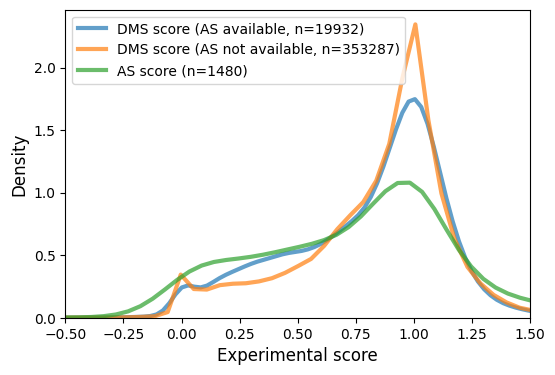

In [8]:
fig = plt.figure(figsize=(6,4))
fig.patch.set_facecolor('w')
kde_kws={'lw':3, 'alpha':0.7}

vis_data = dms_all_as[dms_all_as['Ascan_score_avail']][['dms_id', 'position', 'aa2', 'score']].drop_duplicates()
sns.kdeplot(vis_data['score'], label=f"DMS score (AS available, n={len(vis_data)})", **kde_kws)

vis_data = dms_all_as[~dms_all_as['Ascan_score_avail']][['dms_id', 'position', 'aa2', 'score']].drop_duplicates()
sns.kdeplot(vis_data['score'], label=f"DMS score (AS not available, n={len(vis_data)})", **kde_kws)

vis_data = dms_all_as[dms_all_as['Ascan_score_avail']][['Ascan_id', 'u_pos', 'AS_score']].drop_duplicates()
sns.kdeplot(vis_data['AS_score'], label=f'AS score (n={len(vis_data)})', **kde_kws)

plt.xlim([-0.5, 1.5])
plt.xlabel('Experimental score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

## Data coverage

The following code calculate the number of AS experiments available for each DMS scanned protein residue and reformat data for visualisation.

In [12]:
# Calculate AS experiments available on each (DMS-scanned) protein residue.
prores_as_count = dms_all_as.groupby(['uniprot_id', 'u_pos'])['Ascan_id'].nunique().reset_index()
prores_as_count = prores_as_count.rename(columns={'Ascan_id': 'AS_count'})
prores_as_count.loc[prores_as_count['AS_count']>=6, 'AS_count'] = '≥6'  # Set upper bound.

# Calculate count of protein residues with given number of AS experiments.
res_count = prores_as_count.groupby(['uniprot_id', 'AS_count'], as_index=False).count()
res_count = res_count.pivot(index='uniprot_id', columns='AS_count', values='u_pos').fillna(0)
res_count = res_count.loc[norm_as.uniprot_id.unique()]  # Remove protein without any AS data.
row_order = res_count.iloc[:,1:].sum(axis=1).sort_values(ascending=False).index
col_order = ['≥6', 5, 4, 3, 2, 1, 0]
res_count = res_count.loc[row_order, col_order]
res_count.index = res_count.index.map(data_info.groupby('uniprot_id')['protein_name'].first())

Following code are used to create __Figure 2__.

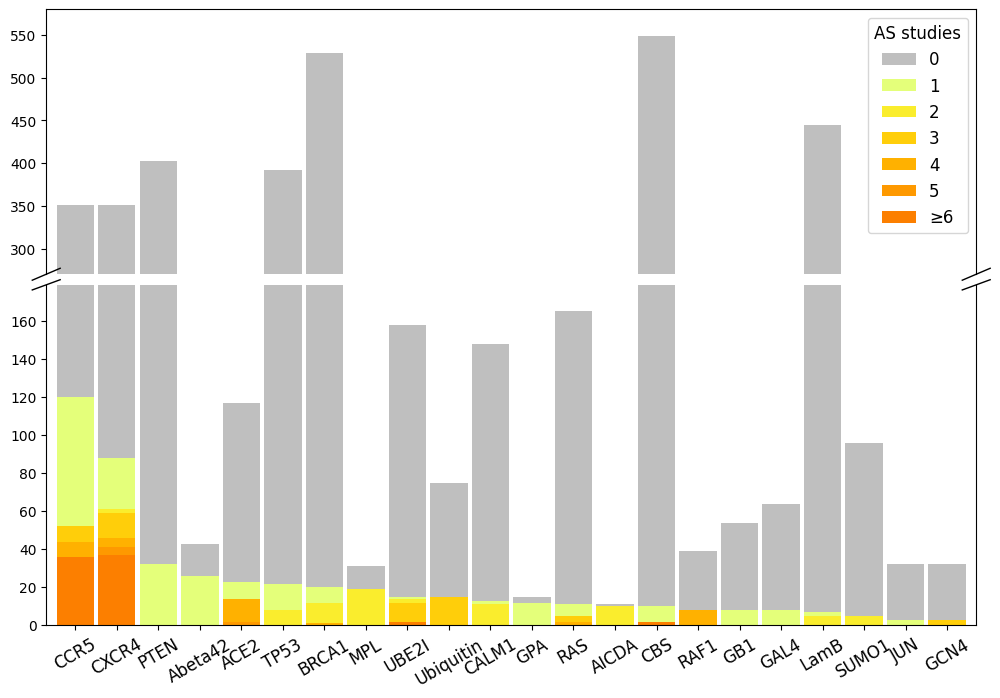

In [19]:
# 1. Set color palette.
hue = []
cmap = plt.cm.get_cmap('Wistia_r', 6)
for i in range(6):
    hue.append(cmap(i))
hue.append([0.75]*3)

# 2. Create main figure.
fig, axs = plt.subplots(2,1,figsize=(12,8),gridspec_kw={'height_ratios':[3.5,4.5]})
fig.patch.set_facecolor('w')
plt.subplots_adjust(hspace=0.035)
for ax in axs:
    res_count.plot(kind='bar', stacked=True, color=hue, width=0.9, ax=ax)
axs[0].set_ylim(270,580)
axs[1].set_ylim(0,179)

# 3. Set legend.
axs[1].legend().remove()
handles, labels = axs[0].get_legend_handles_labels()
legend_order = [6,5,4,3,2,1,0]
axs[0].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order], loc=1, 
              fontsize=12).set_title('AS studies', prop={'size': 12})

# 4. Set spines, ticks and labels.
axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].set_xlabel(None)
axs[1].set_xlabel(None)
axs[0].set_xticks([])
axs[0].set_xticks([], minor=True)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30, fontsize=12)

# 5. Add breaking symbol.
kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False, linewidth=1)
d = .015  # how big to make the diagonal lines in axes coordinates
adjustor = 1.5
axs[0].plot((-d, +d), (-d*adjustor, +d*adjustor), **kwargs)        # top-left diagonal
axs[0].plot((1 - d, 1 + d), (-d*adjustor, +d*adjustor), **kwargs)  # top-right diagonal
kwargs.update(transform=axs[1].transAxes)  # switch to the bottom axes
axs[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axs[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.show()

## Score correlation

Following code are used to show the score correlation between each pair of DMS/AS data, creating __Figure 3__.
* The correlation values were calculated between AS scores and DMS scores of alanine substitutions.
* Data pairs with less than 3 alanine substitutions avaialble are removed, to avoid extreme values.

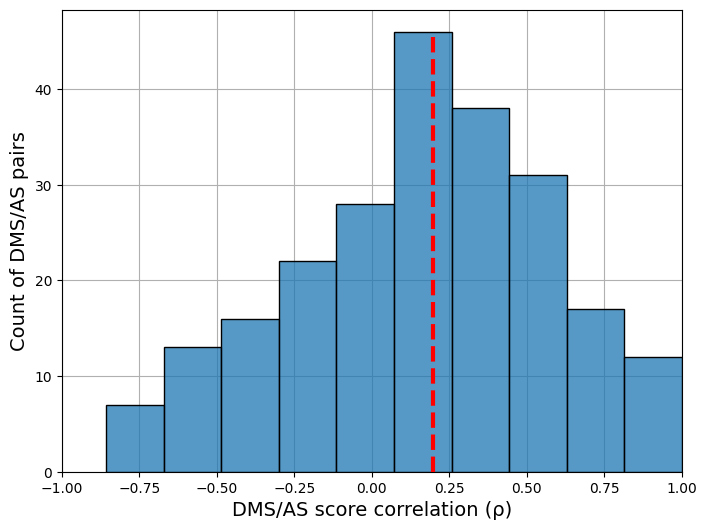

0.19731740661079722


In [12]:
work_data = data_info[['ala_score_correlation', 'n_ala']]
work_data = work_data.query("n_ala >= 3")  # Small ones are removed whose values are usually -1, 0 or 1.

fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
fig.patch.set_facecolor('w')
sns.histplot(work_data['ala_score_correlation'], ax=ax, kde=False, zorder=10)
ax.vlines(work_data['ala_score_correlation'].median(),0,46,linestyle='--',colors='r',linewidth=3, zorder=20)
ax.set_ylabel('Count of DMS/AS pairs', fontsize=14)
ax.set_xlabel('DMS/AS score correlation (ρ)', fontsize=14)
ax.grid(zorder=-10)
ax.set_xlim([-1,1.])
plt.show()

print(work_data['ala_score_correlation'].median())

DMS and AS assay may have different levels of compatibility. 

I manually classified each DMS/AS pair to three levels of assay compatibility: _high_, _medium_ and _low_ which are stored in `data_info`.

Score correlation for data from each level of assay compatibility are shown below, creating __Figure 4.__

The correlation values are calculated and filtered as the above figure.

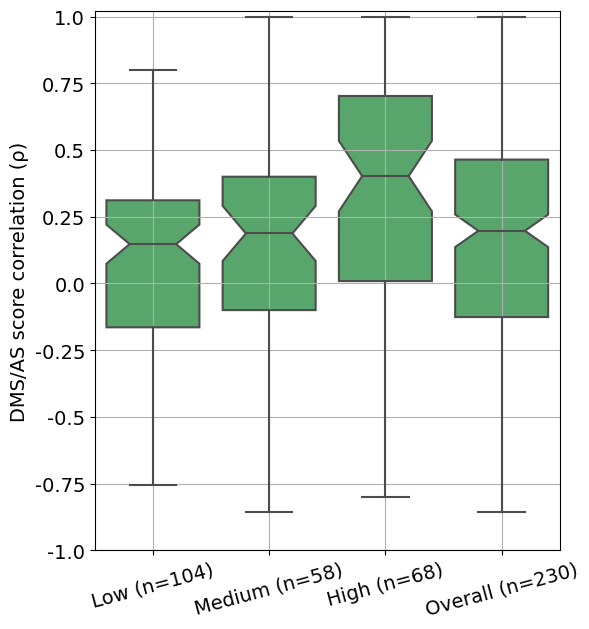

In [17]:
work_data = data_info[['assumed_compatibility', 'ala_score_correlation', 'n_ala']]
work_data = work_data.query("n_ala >= 3")  # Small ones are removed whose values are usually -1, 0 or 1.

# Add overall result.
all_data = work_data.copy()
all_data['assumed_compatibility'] = 'Overall'
work_data = pd.concat([work_data, all_data], ignore_index=True, sort=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 7))
fig.patch.set_facecolor('w')
sns.boxplot(x='assumed_compatibility', y='ala_score_correlation', data=work_data, whis=np.inf, notch=True, 
            color=(0.3, 0.7, 0.4, 1.0), order=['Low', 'Medium', 'High', 'Overall'],
            ax=ax)
# Add pair counts to tick labels.
xticklabels = [x+' (n='+str(len(work_data.query("assumed_compatibility == @x")))+')' 
               for x in ['Low', 'Medium', 'High', 'Overall']]
ax.set_xticklabels(xticklabels, fontsize=14, rotation=15)
ax.set_ylabel('DMS/AS score correlation (ρ)', fontsize=14)
ax.set_xlabel('')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_ylim([-1,1.02])
ax.grid()
plt.show()

In [14]:
work_data.groupby('assumed_compatibility')['ala_score_correlation'].median()

assumed_compatibility
High       0.402473
Low        0.147336
Medium     0.187413
Overall    0.197317
Name: ala_score_correlation, dtype: float64

## Amino acid count

This section shows the count of each wild-type and variant type amino acid in the curated DMS dataset.

Only variants with available AS data are counted.

In [15]:
def data_aa_count_barplot(count_data, vis_on, xlabel, ticks, xlim, ylim):
    """Visualize amino acid count in bar plot.
    """
    fig = plt.figure(figsize=(14, 2.5))
    fig.patch.set_facecolor('w')
    sns.barplot(x=vis_on, y="count", hue="aa_property", data=count_data, dodge=False)
    plt.xticks(ticks=ticks, label=count_data[vis_on])
    plt.xlabel(xlabel)
    plt.ylabel('Entry count', fontsize=12)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(loc=1, ncol=5)
    plt.show()

The following code show wild-type & variant type amino acid count for variant entries with available AS experiments:
1. Filter DMS data with available AS result
2. Count and visualize for each wild-type amino acid
3. Count and visualize for each variant type amino acid

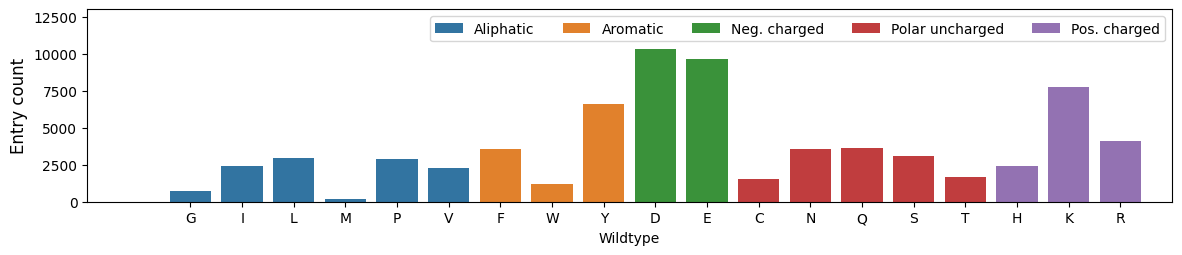

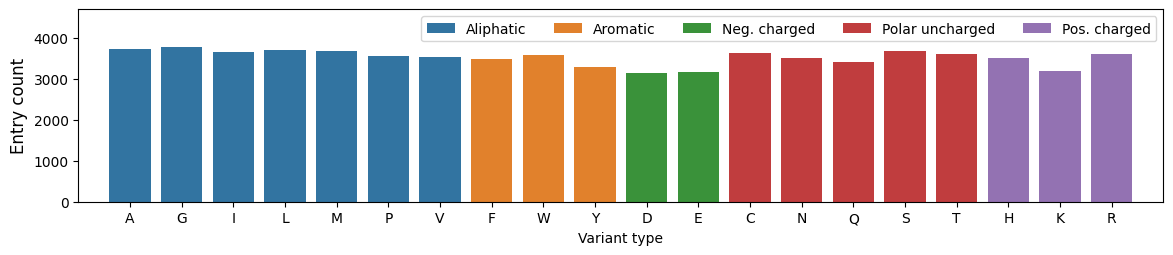

In [16]:
# Select variant data with AS data.
work_data = dms_all_as[dms_all_as['Ascan_score_avail']]

count_data = work_data.groupby('aa1', as_index=False).count()[['score', 'aa1']].rename(columns={'score':'count'})
count_data['aa_property'] = count_data['aa1'].map(AA_PROPERTY)
count_data.sort_values(['aa_property', 'aa1'], inplace=True)
data_aa_count_barplot(count_data, 'aa1', 'Wildtype', np.arange(19), [-2,19], [0,13000])

count_data = work_data.groupby('aa2', as_index=False).count()[['score', 'aa2']].rename(columns={'score':'count'})
count_data['aa_property'] = count_data['aa2'].map(AA_PROPERTY)
count_data.sort_values(['aa_property', 'aa2'], inplace=True)
data_aa_count_barplot(count_data, 'aa2', 'Variant type', np.arange(20), [-1,20], [0,4700])

The following code show wild-type & variant type amino acid count for variant entries with __highly compatible__ AS experiments, creating __Figure S10__:
1. Filter DMS data with AS result of __high assay compatibility__
2. Count and visualize for each wild-type amino acid
3. Count and visualize for each variant type amino acid

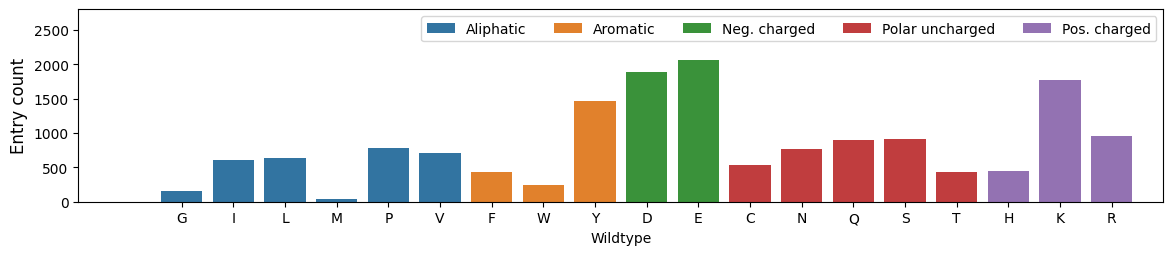

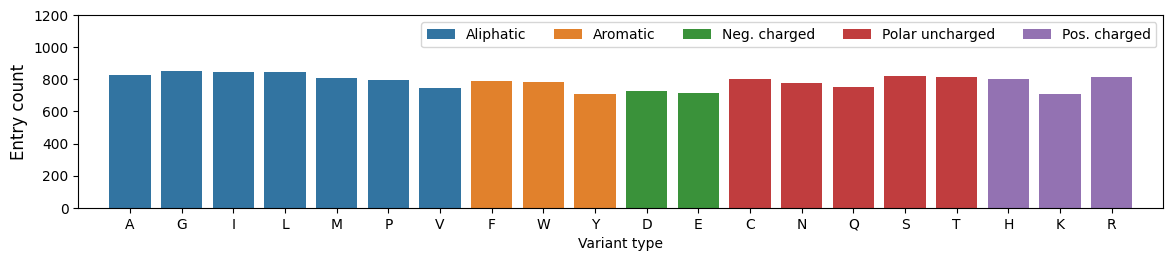

In [17]:
# Select variant data with compatibility filtered AS data.
comp_filter_dmsa = data_info.query("assumed_compatibility == 'High'")['dmsa_id']
work_data = dms_all_as.query("dmsa_id in @comp_filter_dmsa")

count_data = work_data.groupby('aa1', as_index=False).count()[['score', 'aa1']].rename(columns={'score':'count'})
count_data['aa_property'] = count_data['aa1'].map(AA_PROPERTY)
count_data.sort_values(['aa_property', 'aa1'], inplace=True)
data_aa_count_barplot(count_data, 'aa1', 'Wildtype', np.arange(19), [-2,19], [0,2800])

count_data = work_data.groupby('aa2', as_index=False).count()[['score', 'aa2']].rename(columns={'score':'count'})
count_data['aa_property'] = count_data['aa2'].map(AA_PROPERTY)
count_data.sort_values(['aa_property', 'aa2'], inplace=True)
data_aa_count_barplot(count_data, 'aa2', 'Variant type', np.arange(20), [-1,20], [0,1200])